Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.


# SPADE LDM

In this tutorial, we apply SPADE normalisation [1] to a latent diffusion model, in a methodology initially published by Wang et al. [2] to perform semantic image synthesis. 
[1] Park, T., Liu, M.-Y., Wang, T.-C., & Zhu, J.-Y. (2019). Semantic Image Synthesis with Spatially-Adaptive Normalization. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

[2] Wang, W., Bao, J., Zhou, W., Chen, D., Chen, D., Yuan, L., & Li, H. (2022). Semantic Image Synthesis via Diffusion Models. https://doi.org/10.48550/arxiv.2207.00050

In [ ]:
import os
import numpy as np

images_dir = '../datasets/MEDNETPAIRS'
labels_dir = '../datasets/MEDNETPAIRS'

# Filter image and label files
image_files = sorted([
    f for f in os.listdir(images_dir)
    if f.endswith('.png') and not f.endswith('_ah.png')
])

label_files = sorted([
    f for f in os.listdir(labels_dir)
    if f.endswith('.png') and f.endswith('_ah.png')
])

# Match images with corresponding labels
# Assuming the label file has the same name as the image with '_ah.png' at the end
input_dict = []
for img_file in image_files:
    base_name = img_file[:-4]  # Remove '.png'
    label_file = f'{base_name}_ah.png'
    if label_file in label_files:
        input_dict.append({
            'img': os.path.join(images_dir, img_file),
            'mask': os.path.join(labels_dir, label_file)
        })

# Shuffle and split
np.random.shuffle(input_dict)
split_point = int(len(input_dict) * 0.8)
input_dict_train = input_dict[:split_point]
input_dict_val = input_dict[split_point:]


## Setup environment 

In [1]:
#!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
#!python -c "import matplotlib" || pip install -q matplotlib
#!python -c "import gdown" || pip install -q gdown
#%matplotlib inline

## Setup imports

In [2]:
import os
import yaml
import tempfile
import zipfile
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
import gdown
import monai
from dataset import *
from preprocessing import *
from monai.config import print_config
from monai.utils import set_determinism
from monai.data import DataLoader
from monai.networks.nets import SPADEAutoencoderKL, SPADEDiffusionModelUNet, PatchDiscriminator
from monai.networks.schedulers import DDPMScheduler
from monai.losses import PatchAdversarialLoss, PerceptualLoss
from monai.inferers import LatentDiffusionInferer
import yaml
## diosanto
import glob
from monai.transforms import Transform, Compose, Resize, ScaleIntensity, ToTensor, RandAdjustContrast, RandGaussianNoise, RandAffine
from PIL import Image

set_determinism(42)
#print_config()

/home/jovyan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-04-07 17:52:22.596727: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 17:52:22.650860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744041142.674915     283 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory 

## Split data and create dictionaries

In [3]:
#root_dir = '../datasets/DRIVE_dataset/datasets/training'
#print("directory used: %s " % root_dir)

In [4]:
# INPUT PARAMETERS
input_shape = [128, 128]
output_shape = (128,128)
batch_size = 4
num_workers = 2

# for one-hot enconding
label_nc = 2

In [5]:
# Load config
with open("configs.yaml", "r") as f:
    config = yaml.safe_load(f)
    
dataset = config["dataset_paths"][config["dataset_index"]]
if not os.path.exists(dataset):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(dataset))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print(f"Congrats! You selected the correct folder : {dataset}")

Congrats! You selected the correct folder : ../datasets/DRIVE_dataset/datasets/


## Prepare dataloaders

In [45]:
def build_dict_vessels(data_path, mode='training'):
    """
    This function returns a list of dictionaries, each dictionary containing the keys 'img' and 'mask' 
    that returns the path to the corresponding image.
    
    Args:
        data_path (str): path to the root folder of the data set.
        mode (str): subset used. Must correspond to 'train' or 'test'.
        
    Returns:
        (List[Dict[str, str]]) list of the dictionaries containing the paths of images and masks.
    """
    # test if mode is correct
    if mode not in ["training", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'test']. Current mode is {mode}.")
    
    # define empty dictionary
    dicts = []
    # list all files in directory, including the path
    paths_retina = glob.glob(os.path.join(data_path, mode, 'images', '*.tif'))
    #print(paths_retina)
        
    for retina_path in paths_retina:
        image_index = os.path.basename(retina_path).split('_')[0]
        mask_path = os.path.join(data_path, mode, '1st_manual', f'{image_index}_manual1.gif')
        #padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_mask.gif')
        padding_mask_path = os.path.join(data_path, mode, 'mask', f'{image_index}_{mode}_mask.gif')

        #print(padding_mask_path)

        entry = {'img': retina_path}#,
                 #'name': filename}

        # Add segmentation mask if it exists
        if os.path.exists(mask_path):
            #print("mask exist")
            entry['mask'] = mask_path

        # Add valid region mask (padding mask) if it exists
        if os.path.exists(padding_mask_path):
            #print("padding_mask exist")

            entry['valid_mask'] = padding_mask_path

        dicts.append(entry)

    return dicts

class LoadVesselData(Transform):
    """
    This custom Monai transform loads and processes data from the rib segmentation dataset.
    It handles RGB image loading, resizing, normalization, and binary mask conversion.
    """
    def __init__(self, keys=None):
        super().__init__()
        self.keys = keys

    def __call__(self, sample):
        try:
            # Load and process the image
            image = Image.open(sample['img']).convert('L')
            image = image.resize((128, 128), resample=Image.Resampling.NEAREST)
            image = np.array(image, dtype=np.float32) / 255.0
            image = torch.from_numpy(image).unsqueeze(0)  # [1, H, W]

            # Initialize output dictionary
            output = {
                'img': image,
                'img_meta_dict': {'affine': np.eye(2)},
                'name': sample.get('name', 'unknown')  

            }

            # Load segmentation mask if it exists
            if 'mask' in sample and os.path.exists(sample['mask']):
                mask = Image.open(sample['mask']).convert('L')
                mask = mask.resize((512, 512), resample=Image.Resampling.NEAREST)
                mask = np.array(mask, dtype=np.uint8)
                mask = np.where(mask == 255, 1, 0)
                mask = torch.from_numpy(mask).unsqueeze(0).float()
                output['mask'] = mask
                output['mask_meta_dict'] = {'affine': np.eye(2)}

            # Load valid (padding) mask if it exists
            if 'valid_mask' in sample and os.path.exists(sample['valid_mask']):
                valid_mask = Image.open(sample['valid_mask']).convert('L')
                valid_mask = valid_mask.resize((128, 128), resample=Image.Resampling.NEAREST)
                valid_mask = np.array(valid_mask, dtype=np.uint8)
                valid_mask = np.where(valid_mask == 255, 1, 0)
                valid_mask = torch.from_numpy(valid_mask).unsqueeze(0).float()
                output['valid_mask'] = valid_mask

            return output

        except Exception as e:
            print(f"Error processing file: {e}")
            return None



In [46]:
from dataset_stare import *

if config['combination']:
    print("Using STARE+DRIVE")
    main_path = "../datasets"
    stare_images_dir = f"{main_path}/STARE_dataset/images"
    stare_masks_dir = f"{main_path}/STARE_dataset/labels-ah"
    dataset = config["dataset_paths"][config["dataset_index"]] ## Drive dataset

    stare_dicts = build_dict_stare(stare_images_dir, stare_masks_dir)
    drive_dicts = build_dict_vessels(dataset, mode="training")
    train_dict_list = drive_dicts + stare_dicts
    ###test_dict_list = build_dict_vessels(dataset, mode='test')
    
##train_dict_list = build_dict_vessels(dataset, mode='training')
test_dict_list = build_dict_vessels(dataset, mode='test')

print(f'Number of samples in the training dataset: {len(train_dict_list)}')
print(f'Number of samples in the test dataset: {len(test_dict_list)}')

augmentations = [
    #RandAdjustContrast(prob=0.33, gamma=(0.9, 1.1)),
    #RandGaussianNoise(prob=0.33, mean=0.0, std=0.01),
    #RandAffine(prob=0.33, rotate_range=(-0.05, 0.05), shear_range=(0.01, 0.05), scale_range=(0, 0.05), mode='nearest', padding_mode='zeros')
]


# Using 'LoadVesselData' with integrated augmentations
train_transforms = Compose([
    LoadVesselData(),
    ToTensor()
])

val_transforms = Compose([
    LoadVesselData(),
    ToTensor()
])


train_dataset = monai.data.CacheDataset(
    data=train_dict_list, 
    transform = train_transforms
)

train_dataset, val_dataset = split_dataset(train_dataset, train_ratio=0.8)


# Assume 'input_dict_train' and 'input_dict_val' are defined using build_dict_vessels
#train_dataset = monai.data.Dataset(data=train_dict_list, transform=train_transforms)
#val_dataset = monai.data.Dataset(data=val_dict_list, transform=val_transforms)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


Using STARE+DRIVE
Number of samples in the training dataset: 40
Number of samples in the test dataset: 20


Loading dataset: 100%|██████████| 40/40 [00:00<00:00, 53.34it/s]

Dataset split: 32 training samples, 8 testing samples.


torch.Size([4, 1, 128, 128])


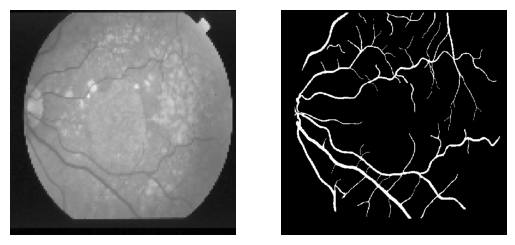

In [47]:
# Sanity check
batch = next(iter(train_loader))
print(batch["img"].shape)
plt.subplot(1, 2, 1)
plt.imshow(batch["img"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(batch["mask"][0, 0, ...], cmap="gist_gray")
plt.axis("off")
plt.show()

### Networks creation and losses

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [49]:
def one_hot(input_label, label_nc):
    # One hot encoding function for the labels
    shape_ = list(input_label.shape)
    shape_[1] = label_nc
    label_out = torch.zeros(shape_)
    for channel in range(label_nc):
        label_out[:, channel, ...] = input_label[:, 0, ...] == channel
    return label_out

In [50]:
def picture_results(input_label, input_image, output_image):
    plt.figure(figsize=(4, 1.5))
    plt.subplot(1, 3, 1)
    plt.imshow(torch.argmax(input_label, 1)[0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Mask")
    plt.subplot(1, 3, 2)
    plt.imshow(input_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Input image")
    plt.subplot(1, 3, 3)
    plt.imshow(output_image[0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Output image")
    plt.show()

SPADE Diffusion Models require two components:
- Autoencoder, incorporating SPADE normalisation in the decoder blocks
- Diffusion model, operating in the latent space, and incorporating SPADE normalisation in the decoding branch

In [99]:
autoencoder = SPADEAutoencoderKL(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_res_blocks=(2, 2, 2, 2),
    channels=(8, 16, 32, 64),
    attention_levels=[False, False, False, False],
    latent_channels=8,
    norm_num_groups=8,
    label_nc=label_nc,
)

In [100]:
diffusion = SPADEDiffusionModelUNet(
    spatial_dims=2,
    in_channels=8,
    out_channels=8,
    num_res_blocks=(2, 2, 2, 2),
    channels=(16, 32, 64, output_shape[0]),
    attention_levels=(False, False, True, True),
    norm_num_groups=16,
    with_conditioning=False,
    label_nc=label_nc,
)

To train the autoencoder, we are using **a Patch-GAN-based adversarial loss**, a **perceptual loss** and a basic **L1 loss** between input and output.

In [101]:
device = "cuda" if torch.cuda.is_available() else "cpu"
perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex").to(device)

In [102]:
discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    channels=16,
    in_channels=1,
    out_channels=1,
)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [103]:
recon = torch.nn.L1Loss()

In [104]:
optimizer_g = torch.optim.Adam(autoencoder.parameters(), lr=0.0002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0004)
# For mixed precision training
scaler_g = torch.amp.GradScaler("cuda")
scaler_d = torch.amp.GradScaler("cuda")

## Training the AutoencoderKL

We used the exact same approach as the one from the 2d_ldm_tutorial to train the autoencoder.

In [105]:
# Loss weights and number of epochs
kl_weight = 1e-6
max_epochs = 400
val_interval = 20
adv_weights = 0.01
autoencoder_warm_up_n_epochs = 10
perceptual_weight = 0.001

Train: reconstruction: 0.367990; generator: 0.000000; discriminator: 0.000000; perceptual: 0.073547; kld: 397.921838
Train: reconstruction: 0.091668; generator: 0.000000; discriminator: 0.000000; perceptual: 0.048798; kld: 624.426588


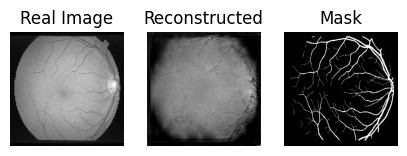

epoch 20 val loss: 0.1336
Train: reconstruction: 0.057618; generator: 0.544379; discriminator: 0.152054; perceptual: 0.039124; kld: 824.543233
Train: reconstruction: 0.049526; generator: 0.778035; discriminator: 0.025640; perceptual: 0.027802; kld: 859.207058


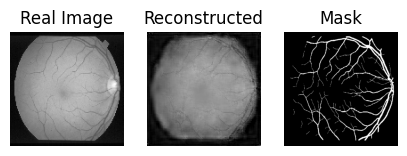

epoch 40 val loss: 0.1228
Train: reconstruction: 0.043843; generator: 0.662270; discriminator: 0.057774; perceptual: 0.021576; kld: 835.035522
Train: reconstruction: 0.043860; generator: 0.701957; discriminator: 0.076056; perceptual: 0.020157; kld: 791.573717


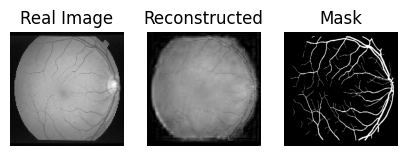

epoch 60 val loss: 0.1360
Train: reconstruction: 0.042486; generator: 0.674865; discriminator: 0.132177; perceptual: 0.015083; kld: 810.958693
Train: reconstruction: 0.035577; generator: 0.820809; discriminator: 0.021898; perceptual: 0.016434; kld: 793.244168


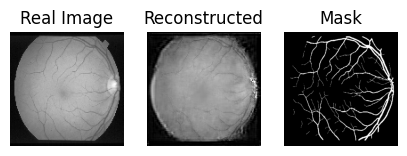

epoch 80 val loss: 0.1324
Train: reconstruction: 0.032807; generator: 0.722000; discriminator: 0.056353; perceptual: 0.016296; kld: 838.913486
Train: reconstruction: 0.029834; generator: 0.826016; discriminator: 0.027843; perceptual: 0.014702; kld: 862.972534


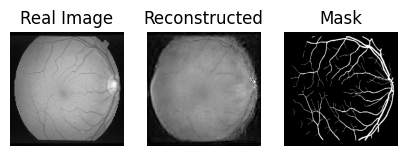

epoch 100 val loss: 0.1090
Train: reconstruction: 0.026301; generator: 0.840886; discriminator: 0.024186; perceptual: 0.014687; kld: 881.669352
Train: reconstruction: 0.025231; generator: 0.939154; discriminator: 0.008066; perceptual: 0.012360; kld: 861.807916


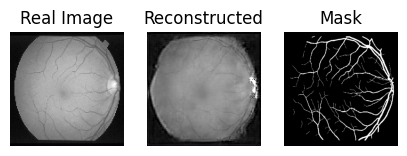

epoch 120 val loss: 0.1069
Train: reconstruction: 0.024775; generator: 0.939090; discriminator: 0.008304; perceptual: 0.012642; kld: 819.661255
Train: reconstruction: 0.026182; generator: 0.891605; discriminator: 0.006455; perceptual: 0.006428; kld: 839.793939


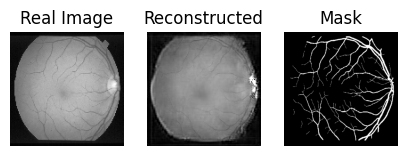

epoch 140 val loss: 0.1141
Train: reconstruction: 0.026141; generator: 0.696506; discriminator: 0.035916; perceptual: 0.011314; kld: 825.395352
Train: reconstruction: 0.025618; generator: 0.916290; discriminator: 0.018333; perceptual: 0.008049; kld: 808.722026


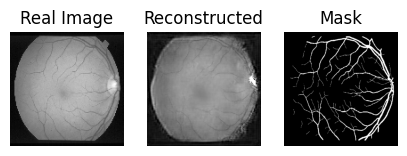

epoch 160 val loss: 0.1055
Train: reconstruction: 0.024809; generator: 0.692905; discriminator: 0.050544; perceptual: 0.011215; kld: 807.942261
Train: reconstruction: 0.023219; generator: 0.723577; discriminator: 0.042080; perceptual: 0.009415; kld: 801.226386


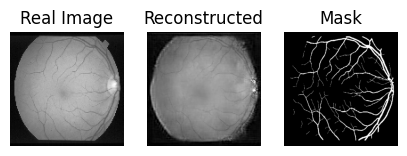

epoch 180 val loss: 0.1077
Train: reconstruction: 0.021913; generator: 0.926191; discriminator: 0.008715; perceptual: 0.007549; kld: 781.699843
Train: reconstruction: 0.019811; generator: 0.912967; discriminator: 0.006341; perceptual: 0.007114; kld: 766.428155


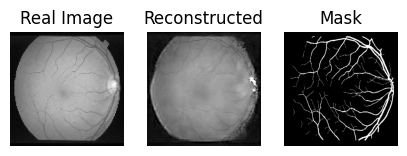

epoch 200 val loss: 0.1038
Train: reconstruction: 0.019832; generator: 0.847494; discriminator: 0.025267; perceptual: 0.007046; kld: 766.275194
Train: reconstruction: 0.021395; generator: 0.895942; discriminator: 0.038792; perceptual: 0.007088; kld: 744.739624


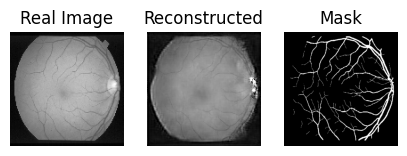

epoch 220 val loss: 0.1065
Train: reconstruction: 0.020325; generator: 0.878696; discriminator: 0.016388; perceptual: 0.008965; kld: 744.284132
Train: reconstruction: 0.018354; generator: 0.953420; discriminator: 0.003133; perceptual: 0.007904; kld: 731.743517


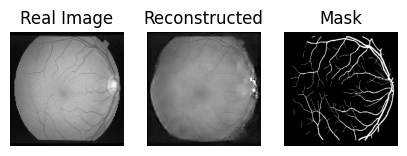

epoch 240 val loss: 0.0989
Train: reconstruction: 0.018689; generator: 0.929823; discriminator: 0.001951; perceptual: 0.010063; kld: 734.155775
Train: reconstruction: 0.017482; generator: 0.921127; discriminator: 0.001562; perceptual: 0.005711; kld: 735.915948


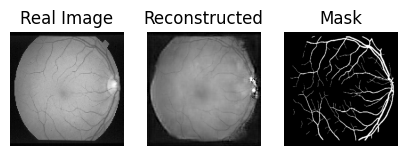

epoch 260 val loss: 0.0989
Train: reconstruction: 0.019402; generator: 0.903060; discriminator: 0.002166; perceptual: 0.004684; kld: 715.215597
Train: reconstruction: 0.018332; generator: 0.863372; discriminator: 0.010247; perceptual: 0.007248; kld: 710.983154


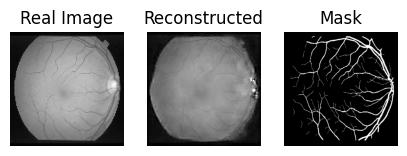

epoch 280 val loss: 0.1070
Train: reconstruction: 0.017538; generator: 0.916954; discriminator: 0.002216; perceptual: 0.004658; kld: 703.422601
Train: reconstruction: 0.017302; generator: 0.938451; discriminator: 0.005426; perceptual: 0.006516; kld: 710.433377


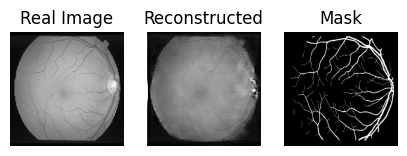

epoch 300 val loss: 0.1084
Train: reconstruction: 0.019558; generator: 0.952578; discriminator: 0.014908; perceptual: 0.009621; kld: 682.232510
Train: reconstruction: 0.017479; generator: 0.939978; discriminator: 0.005206; perceptual: 0.004669; kld: 668.445516


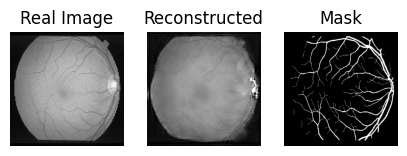

epoch 320 val loss: 0.1059
Train: reconstruction: 0.018153; generator: 0.919643; discriminator: 0.005126; perceptual: 0.005146; kld: 661.357015
Train: reconstruction: 0.020653; generator: 0.947797; discriminator: 0.002794; perceptual: 0.006718; kld: 645.157220


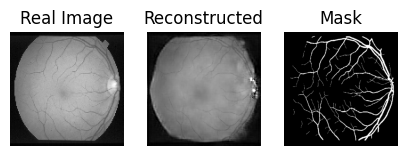

epoch 340 val loss: 0.1068
Train: reconstruction: 0.016019; generator: 0.942612; discriminator: 0.002464; perceptual: 0.003983; kld: 650.266880
Train: reconstruction: 0.014560; generator: 0.904353; discriminator: 0.001360; perceptual: 0.003431; kld: 632.412618


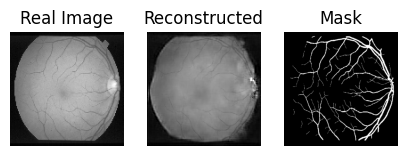

epoch 360 val loss: 0.1030
Train: reconstruction: 0.016070; generator: 0.939214; discriminator: 0.003700; perceptual: 0.004883; kld: 621.292738
Train: reconstruction: 0.017530; generator: 0.933685; discriminator: 0.000981; perceptual: 0.003880; kld: 598.862874


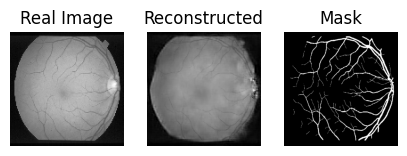

epoch 380 val loss: 0.1079
Train: reconstruction: 0.015991; generator: 0.906119; discriminator: 0.001494; perceptual: 0.002968; kld: 599.212158
Train: reconstruction: 0.015638; generator: 0.902530; discriminator: 0.002262; perceptual: 0.005878; kld: 593.812391


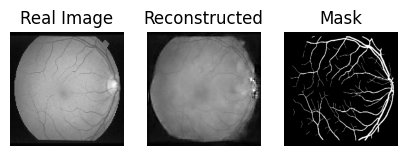

epoch 400 val loss: 0.1064


In [106]:
autoencoder.to(device)

# Loss storage
epoch_recon_losses = []
epoch_perc_losses = []
epoch_kld_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []

for epoch in range(max_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    perceptual_epoch_loss = 0
    kld_epoch_loss = 0
    for batch in train_loader:
        images = batch["img"].to(device)
        labels = one_hot(batch["mask"], label_nc).to(device)
        optimizer_g.zero_grad(set_to_none=True)

        with autocast(device_type="cuda", enabled=True):
            reconstruction, z_mu, z_sigma = autoencoder(images, labels)
            recons_loss = recon(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(device_type="cuda", enabled=True):
                optimizer_d.zero_grad(set_to_none=True)
                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        perceptual_epoch_loss += p_loss.item()
        kld_epoch_loss += kl_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

    num_steps = len(train_loader) + 1
    epoch_recon_losses.append(epoch_loss / num_steps)
    epoch_gen_losses.append(gen_epoch_loss / num_steps)
    epoch_disc_losses.append(disc_epoch_loss / num_steps)
    epoch_perc_losses.append(p_loss / num_steps)
    epoch_kld_losses.append(kld_epoch_loss / num_steps)

    if epoch % 10 == 0:
        msgs = [
            f"Train: reconstruction: {epoch_recon_losses[-1]:4f}",
            f" generator: {epoch_gen_losses[-1]:4f}",
            f" discriminator: {epoch_disc_losses[-1]:4f}",
            f" perceptual: {epoch_perc_losses[-1]:4f}",
            f" kld: {epoch_kld_losses[-1]:4f}",
        ]
        print(";".join(msgs))

    if (epoch + 1) % val_interval == 0:
        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=0):
                images = batch["img"].to(device)
                labels = one_hot(batch["mask"], label_nc).to(device)
                with autocast(device_type="cuda", enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoder(images, labels)
                    ##recons_loss = recon(images.float(), reconstruction.float())
                    if "valid_mask" in batch:
                        valid_mask = batch["valid_mask"].to(device)
                        reconstruction_masked = (reconstruction * valid_mask).detach().cpu()
                        # Multiply the predictions and targets by the valid_mask
                        recons_loss = recon(reconstruction.float() * valid_mask, images.float() * valid_mask)
                    else:
                        recons_loss = recon(reconstruction.float(), images.float())
                        reconstruction_masked = reconstruction.detach().cpu()


                val_loss += recons_loss.item()
                # We retrieve the image to plot
                if val_step == 0:
                    reconstruction = reconstruction.detach().cpu()
                    #reconstruction_masked = reconstruction * valid_mask
                    plt.figure(figsize=(5, 3))
                    plt.subplot(1, 3, 1)
                    plt.imshow(images[0, 0, ...].detach().cpu(), cmap="gist_gray")
                    plt.axis("off")
                    plt.title("Real Image")
                    plt.subplot(1, 3, 2)
                    plt.imshow(
                        reconstruction_masked[0, 0, ...], 
                        cmap="gray", 
                        vmin=0.0, vmax=1.0
                    )
                    plt.axis("off")
                    plt.title("Reconstructed")

                    plt.subplot(1, 3, 3)
                    plt.imshow(batch["mask"][0, 0, ...].detach().cpu(), cmap="gray")
                    plt.axis("off")
                    plt.title("Mask")
                    plt.savefig(f"rec_{epoch}.png", bbox_inches="tight", dpi=300)

                    plt.show()

        val_loss /= max(val_step, 1)
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

## Training the diffusion model

Likewise, we use the same approach as in the 2d_ldm_tutorial.

In [107]:
scheduler = DDPMScheduler(num_train_timesteps=500, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)
optimizer = torch.optim.Adam(diffusion.parameters(), lr=1e-4)
inferer = LatentDiffusionInferer(scheduler, scale_factor=1.0)

Epoch 0 / 500
training loss: 0.8790
Epoch 10 / 500
training loss: 0.8254
Epoch 20 / 500
training loss: 0.7559
Epoch 30 / 500
training loss: 0.6801
Epoch 39 val loss: 0.4622


100%|██████████| 500/500 [00:15<00:00, 32.09it/s]


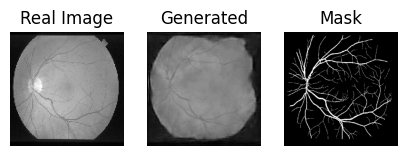

Epoch 40 / 500
training loss: 0.6466
Epoch 50 / 500
training loss: 0.6313
Epoch 60 / 500
training loss: 0.5542
Epoch 70 / 500
training loss: 0.5404
Epoch 79 val loss: 0.3645


100%|██████████| 500/500 [00:15<00:00, 32.89it/s]


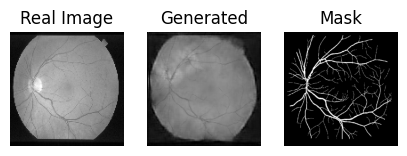

Epoch 80 / 500
training loss: 0.5819
Epoch 90 / 500
training loss: 0.4712
Epoch 100 / 500
training loss: 0.4265
Epoch 110 / 500
training loss: 0.4885
Epoch 119 val loss: 0.4613


100%|██████████| 500/500 [00:15<00:00, 32.83it/s]


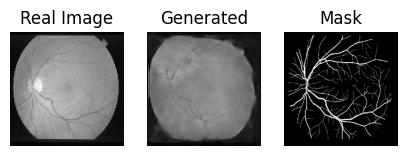

Epoch 120 / 500
training loss: 0.5000
Epoch 130 / 500
training loss: 0.4383
Epoch 140 / 500
training loss: 0.3856
Epoch 150 / 500
training loss: 0.3634
Epoch 159 val loss: 0.2900


100%|██████████| 500/500 [00:15<00:00, 32.12it/s]


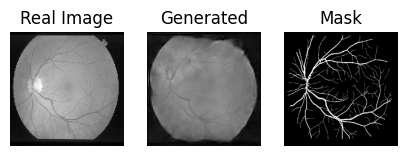

Epoch 160 / 500
training loss: 0.4432
Epoch 170 / 500
training loss: 0.3681
Epoch 180 / 500
training loss: 0.4138
Epoch 190 / 500
training loss: 0.3678
Epoch 199 val loss: 0.2627


100%|██████████| 500/500 [00:19<00:00, 25.93it/s]


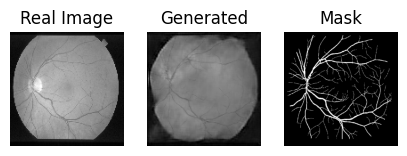

Epoch 200 / 500
training loss: 0.3460
Epoch 210 / 500
training loss: 0.3479
Epoch 220 / 500
training loss: 0.3283
Epoch 230 / 500
training loss: 0.3511
Epoch 239 val loss: 0.2291


100%|██████████| 500/500 [00:19<00:00, 25.75it/s]


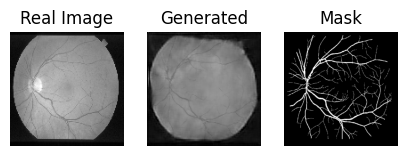

Epoch 240 / 500
training loss: 0.4094
Epoch 250 / 500
training loss: 0.3046
Epoch 260 / 500
training loss: 0.3147
Epoch 270 / 500
training loss: 0.3500
Epoch 279 val loss: 0.2097


100%|██████████| 500/500 [00:18<00:00, 26.50it/s]


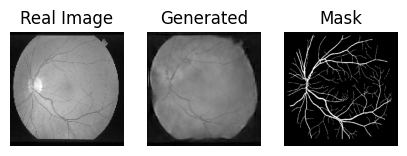

Epoch 280 / 500
training loss: 0.3917
Epoch 290 / 500
training loss: 0.4326
Epoch 300 / 500
training loss: 0.3170
Epoch 310 / 500
training loss: 0.3293
Epoch 319 val loss: 0.1664


100%|██████████| 500/500 [00:16<00:00, 31.19it/s]


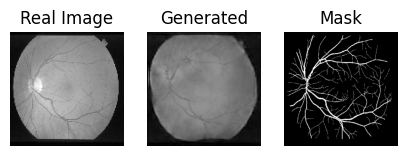

Epoch 320 / 500
training loss: 0.3297
Epoch 330 / 500
training loss: 0.3405
Epoch 340 / 500
training loss: 0.3482
Epoch 350 / 500
training loss: 0.2931
Epoch 359 val loss: 0.3345


100%|██████████| 500/500 [00:15<00:00, 31.69it/s]


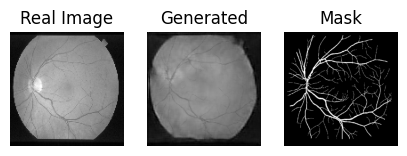

Epoch 360 / 500
training loss: 0.3136
Epoch 370 / 500
training loss: 0.2706
Epoch 380 / 500
training loss: 0.4135
Epoch 390 / 500
training loss: 0.3251
Epoch 399 val loss: 0.3611


100%|██████████| 500/500 [00:15<00:00, 32.74it/s]


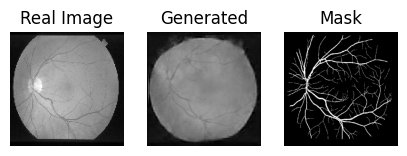

Epoch 400 / 500
training loss: 0.3446
Epoch 410 / 500
training loss: 0.3094
Epoch 420 / 500
training loss: 0.3536
Epoch 430 / 500
training loss: 0.3374
Epoch 439 val loss: 0.3289


100%|██████████| 500/500 [00:15<00:00, 32.99it/s]


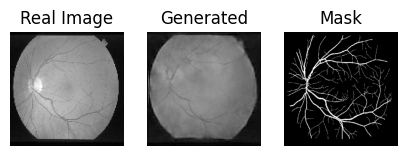

Epoch 440 / 500
training loss: 0.3241
Epoch 450 / 500
training loss: 0.2944
Epoch 460 / 500
training loss: 0.2657
Epoch 470 / 500
training loss: 0.3612
Epoch 479 val loss: 0.2235


100%|██████████| 500/500 [00:15<00:00, 32.01it/s]


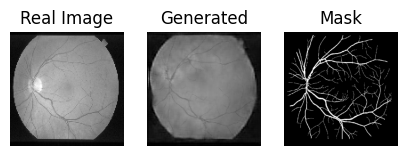

Epoch 480 / 500
training loss: 0.3989
Epoch 490 / 500
training loss: 0.3113


In [108]:
diffusion = diffusion.to(device)
max_epochs = 500
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler("cuda")

for epoch in range(max_epochs):
    if epoch % 10 == 0:
        print("Epoch %d / %d" % (epoch, max_epochs))
    diffusion.train()
    autoencoder.eval()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["img"].to(device)
        labels = one_hot(batch["mask"], label_nc).to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", enabled=True):
            z_mu, z_sigma = autoencoder.encode(images)
            z = autoencoder.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images,
                diffusion_model=diffusion,
                noise=noise,
                timesteps=timesteps,
                autoencoder_model=autoencoder,
                seg=labels,
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    epoch_losses.append(epoch_loss / (len(train_loader) + 1))
    if epoch % 10 == 0:
        print("training loss: %.4f" % (epoch_losses[-1]))

    if (epoch + 1) % val_interval == 0:
        diffusion.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                images = batch["img"].to(device)
                labels = one_hot(batch["mask"], label_nc).to(device)
                with autocast(device_type="cuda", enabled=True):
                    z_mu, z_sigma = autoencoder.encode(images)

                    z = autoencoder.sampling(z_mu, z_sigma)
                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=diffusion,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoder,
                        seg=labels,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= len(val_loader) + 1
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training. We use the last segmentation of our loader
        z = torch.randn((labels.shape[0], 8, 16, 16)).to(device)
        scheduler.set_timesteps(num_inference_steps=500)
        with autocast(device_type="cuda", enabled=True):
            decoded = inferer.sample(
                input_noise=z, 
                diffusion_model=diffusion, 
                scheduler=scheduler, 
                autoencoder_model=autoencoder, 
                seg=labels
            )
            
        # Apply the valid mask if available
        if "valid_mask" in batch:
            valid_mask = batch["valid_mask"].to(device)
            decoded_masked = (decoded * valid_mask).detach().cpu()
        else:
            decoded_masked = decoded.detach().cpu()

        plt.figure(figsize=(5, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(images[0, 0, ...].detach().cpu(), cmap="gist_gray")
        plt.axis("off")
        plt.title("Real Image")

        plt.subplot(1, 3, 2)
        plt.imshow(
            decoded_masked[0, 0, ...], 
            cmap="gray", 
            vmin=0.0, vmax=1.0
        )
        plt.axis("off")
        plt.title("Generated")

        plt.subplot(1, 3, 3)
        plt.imshow(batch["mask"][0, 0, ...].detach().cpu(), cmap="gray")
        plt.axis("off")
        plt.title("Mask")
        plt.savefig(f"gen_{epoch+1}.png", bbox_inches="tight", dpi=300)
        plt.show()

## outside training

In [76]:
## Generate Outside of training
diffusion.eval()
autoencoder.eval()

# Dummy noise and label (or real one from your val_loader)
z = torch.randn((1, 8, 16, 16)).to(device)
segmentation = next(iter(val_loader))["mask"][:1].to(device)
segmentation = one_hot(segmentation, label_nc).to(device)

scheduler.set_timesteps(num_inference_steps=500)
with torch.no_grad(), autocast(device_type="cuda", enabled=True):
    generated = inferer.sample(
        input_noise=z,
        diffusion_model=diffusion,
        scheduler=scheduler,
        autoencoder_model=autoencoder,
        seg=segmentation,
    )

100%|██████████| 500/500 [00:17<00:00, 28.66it/s]


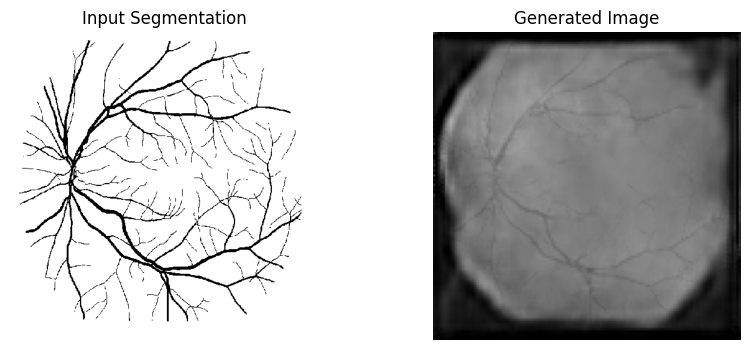

In [82]:
# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(segmentation[0, 0].detach().cpu(), cmap="gray")
plt.axis("off")
plt.title("Input Segmentation")

plt.subplot(1, 2, 2)
plt.imshow(generated[0, 0].detach().cpu(), cmap="gray", 
            vmin=0.0, vmax=1.0)
plt.axis("off")
plt.title("Generated Image")

plt.show()  # Or use plt.savefig("gen.png")


100%|██████████| 500/500 [00:14<00:00, 33.94it/s]


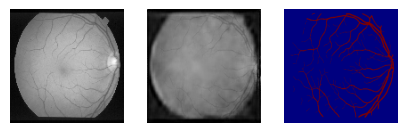

100%|██████████| 500/500 [00:14<00:00, 33.96it/s]


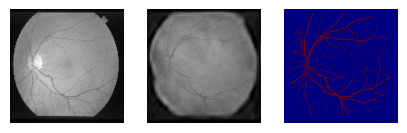

StopIteration: 

In [84]:
# Varying the segmentation mask using different samples from the validation loader
val_iter = iter(val_loader)
for i in range(3):  # Generate 3 different outputs
    # Get a different segmentation mask from the validation set
    batch = next(val_iter)
    segmentation = batch["mask"][:1].to(device)
    segmentation = one_hot(segmentation, label_nc).to(device)
    
    # Sample a new noise vector for each output
    z = torch.randn((1, 8, 16, 16)).to(device)
    
    scheduler.set_timesteps(num_inference_steps=500)
    with torch.no_grad(), autocast(device_type="cuda", enabled=True):
        generated = inferer.sample(
            input_noise=z,
            diffusion_model=diffusion,
            scheduler=scheduler,
            autoencoder_model=autoencoder,
            seg=segmentation,
        )
    
    # Plot the generated image
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(batch["img"][0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(
        generated[0, 0, ...].detach().cpu(), 
        cmap="gray", 
        vmin=0.0, vmax=1.0
    )
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(batch["mask"][0, 0, ...].detach().cpu(), cmap="jet")
    plt.axis("off")
    plt.show()

# Alternatively, if you want to see variations with the same segmentation mask:
batch = next(iter(val_loader))
segmentation = batch["mask"][:1].to(device)
segmentation = one_hot(segmentation, label_nc).to(device)

for i in range(3):  # Generate 3 variations with the same mask but different noise
    z = torch.randn((1, 8, 16, 16)).to(device)
    
    scheduler.set_timesteps(num_inference_steps=500)
    with torch.no_grad(), autocast(device_type="cuda", enabled=True):
        generated = inferer.sample(
            input_noise=z,
            diffusion_model=diffusion,
            scheduler=scheduler,
            autoencoder_model=autoencoder,
            seg=segmentation,
        )
    
    # Plot the generated image
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(batch["img"][0, 0, ...].detach().cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Real Image")

    plt.subplot(1, 3, 2)
    plt.imshow(
        generated[0, 0, ...].detach().cpu(), 
        cmap="gray", 
        vmin=0.0, vmax=1.0
    )
    plt.axis("off")
    plt.title("Generated Image")

    plt.subplot(1, 3, 3)
    plt.imshow(batch["mask"][0, 0, ...].detach().cpu(), cmap="gray")
    plt.axis("off")
    plt.title("Real Mask")

    plt.show()


100%|██████████| 500/500 [00:17<00:00, 28.85it/s]


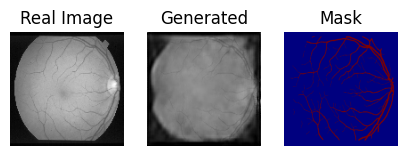

100%|██████████| 500/500 [00:17<00:00, 28.89it/s]


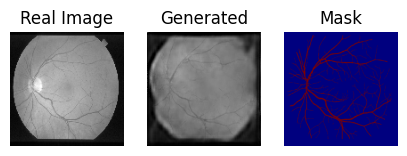

StopIteration: 

In [78]:
import random

diffusion.eval()
autoencoder.eval()
val_iter = iter(val_loader)

for i in range(5):
    batch = next(val_iter)
    # Pick a random sample from the batch
    idx = random.randint(0, batch["mask"].shape[0] - 1)
    
    # Use that mask for conditioning
    seg = batch["mask"][idx:idx+1].to(device)
    seg = one_hot(seg, label_nc).to(device)

    # Sample random noise
    z = torch.randn((1, 8, 16, 16)).to(device)

    # Generate with the chosen mask
    scheduler.set_timesteps(num_inference_steps=500)
    with torch.no_grad(), autocast(device_type="cuda", enabled=True):
        generated = inferer.sample(
            input_noise=z,
            diffusion_model=diffusion,
            scheduler=scheduler,
            autoencoder_model=autoencoder,
            seg=seg,
        )

    # Visualize
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(batch["img"][idx, 0, ...].cpu(), cmap="gist_gray")
    plt.axis("off")
    plt.title("Real Image")

    plt.subplot(1, 3, 2)
    plt.imshow(generated[0, 0, ...].cpu(), cmap="gray", vmin=0.0, vmax=1.0)
    plt.axis("off")
    plt.title("Generated")

    plt.subplot(1, 3, 3)
    plt.imshow(batch["mask"][idx, 0, ...].cpu(), cmap="jet")
    plt.axis("off")
    plt.title("Mask")
    plt.show()
